---
# Comparison partial FOV anatomies with Whole-Brain Anatomy

This notebook highlights different options for the following problems: 1) how accuracte is the planning going from session 1 to session 2 and; 2) how much movement is there in between functional runs during session 2. The first problem might be tackled with high resolution anatomical imaging using the 2-channel transceive elements of the volume coil. The second problem might be mapped using fast EPI BOLD acquisitions that are hopefully amenable to motion correction following standard pipelines.

The following acquisitions were made in separate sessions and (unfortunately) subjects:

`sub-004`:
- High resolution `"SWI"` imaging (0.6x0.6x1.3, surface coils) of 20 slices. This acquisition took 187 seconds. This volume was reduced to 10 slices in steps of 2. This 10 slices image should then take ~(187/2 =) 93s = 1.33mins?
    - run-4: 20 slices
    - run-5: 18 slices
    - run-6: 16 slices
    - run-7: 14 slices
    - run-8: 12 slices
    - run-9: 10 slices

- Each of these runs was independently registered to `orig_in_ses3.nii.gz` (the image resulting from applying the `sub-004_from-fs_to-ses3_desc-genaff.mat` to $SUBJECTS_DIR/sub-004/mri/orig.nii.gz while retaining the resolution) using `call_antspartialfov`. This script creates a mask of the partial FOV image to include only those voxels in the registration (`--masks` option in `antsRegistration`). Then it registers the image using `antsRegistration` and applies the matrix to the input image, resulting in a `run-?.nii.gz` image (1 for each run). 

- Goals:
    - Visually compare alignment of `run-?.nii.gz` to `orig_in_ses3.nii.gz`
    - Compare translation/rotation indices obtained from `run-?_desc-genaff.mat`
    
`sub-005`:
- High resolution `MP2RAGE` (0.9iso; volume coil), covering the visual cortex up until the posterior part of the corpus callosum
- 2mm iso `EPI BOLD` (volume coil)
- Goals:
    - Assess usability of partial FOV MP2RAGE for registration with session 1
    - Assess usability of partial FOV MP2RAGE for registration with BOLD

In [1]:
# imports
%reload_ext autoreload
%autoreload 2
from linescanning import utils,glm,prf
import nibabel as nb
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

opj = os.path.join
base, place = utils.get_base_dir()

base_dir = opj(base, 'projects', 'hemifield')
fig_dir = opj(base_dir, 'code', 'figures', 'prf')

/home/heij/.conda/envs/mpl/lib/python3.10/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/heij/.conda/envs/mpl/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


---
# sub-004: Multiple 'SWI' acquisition schemes

Below the comparison between the 'SWI' acquisition with different numbers of slices. It's technically not really SWI, but that's how the sequence was named. Anyway, it's pretty high resolution in all planes (possibly too much even), which gives the registration algorithm something to hold on to.

In [9]:
class PartialFOV():

    def __init__(self, file, xfm=None, slices=[195,167,58]):
        
        self.slices = slices
        self.img_file = file
        self.genaff_file = xfm

        if self.genaff_file != None:
            self.genaff_data = utils.get_matrixfromants(self.genaff_file)
        
        self.img = nb.load(self.img_file)
        self.img_data = self.img.get_fdata()

        if self.img_data.ndim > 3:
            self.img_data = np.squeeze(self.img_data, axis=-1)

        self.img_slice_ax = np.rot90(self.img_data[:,self.slices[1],:])
        self.img_slice_cor = np.rot90(self.img_data[:,:,self.slices[2]],k=3)
        self.img_slice_sag = np.fliplr(self.img_data[self.slices[0],:,:])

    def overlay_ref(self, ref=None, alpha=0.6, figsize=(20,5), title=None, cmap1="Greys_r", cmap2="viridis"):
        
        if isinstance(ref, str):
            ref_data = nb.load(ref).get_fdata()
        elif isinstance(ref, nb.Nifti1Image):
            ref_data = ref.get_fdata()
        elif isinstance(ref, np.ndarray):
            ref_data = ref.copy()
        else:
            raise ValueError("Unrecognized input type for <ref>")
        
        if ref_data.ndim > 3:
            ref_data = np.squeeze(ref_data, axis=-1)
        # print(f"orig has shape: {ref_data.shape}")

        fig,axs = plt.subplots(1,3, figsize=figsize)
        axs[0].imshow(np.rot90(ref_data[:,self.slices[1],:]), cmap=cmap1)
        axs[0].imshow(self.img_slice_ax, cmap=cmap2, alpha=alpha)
        axs[0].axis('off')

        axs[1].imshow(np.rot90(ref_data[:,:,self.slices[2]],k=3), cmap=cmap1)
        axs[1].imshow(self.img_slice_cor, cmap=cmap2, alpha=alpha)
        axs[1].axis('off')

        axs[2].imshow(np.fliplr(ref_data[self.slices[0],:,:]), cmap=cmap1)
        axs[2].imshow(self.img_slice_sag, cmap=cmap2, alpha=alpha)
        axs[2].axis('off')

        if title != None:
            plt.suptitle(title).set_fontsize(14)

        plt.tight_layout()

    def return_matrix(self):
        return self.genaff_data

    def return_rotation(self, unit="deg"):
        
        angles = nb.affines.obliquity(self.genaff_data)
        if unit == "deg":
            return np.degrees(angles)
        else:
            return angles

    def return_translation(self):
        return self.genaff_data[:3,-1]

    def affine_to_degrees(self, unit='rad'):
        np.set_printoptions(precision=8)
        angles = nb.affines.obliquity(self.img.affine)

        if unit == "rad":
            return angles
        elif unit == "deg":
            return np.degrees(angles)
        else:
            raise ValueError(f"Unrecognized unit '{unit}'; should be 'deg' or 'rad'")

## Visual comparison

run-4 obliquity = 	 [0.00037002 0.00026164 0.00026164]
run-5 obliquity = 	 [0.00037002 0.00026164 0.00026164]
run-6 obliquity = 	 [0.00037002 0.00026164 0.00026164]
run-7 obliquity = 	 [0.00037002 0.00026164 0.00026164]
run-8 obliquity = 	 [0.00037002 0.00026164 0.00026164]
run-9 obliquity = 	 [0.00037002 0.00026164 0.00026164]


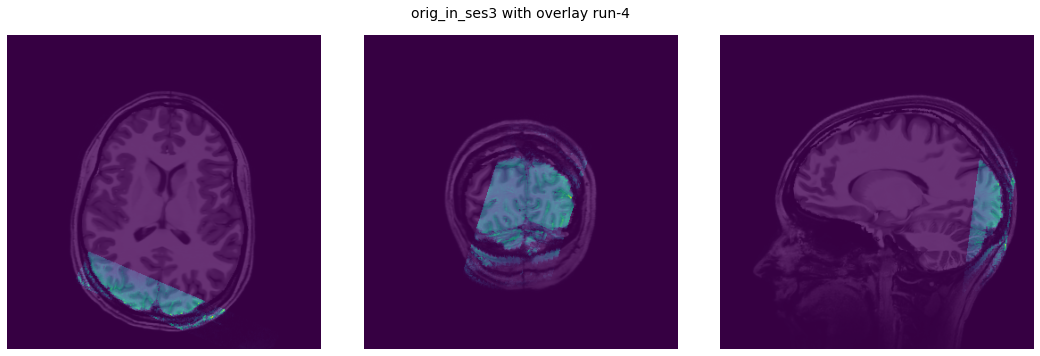

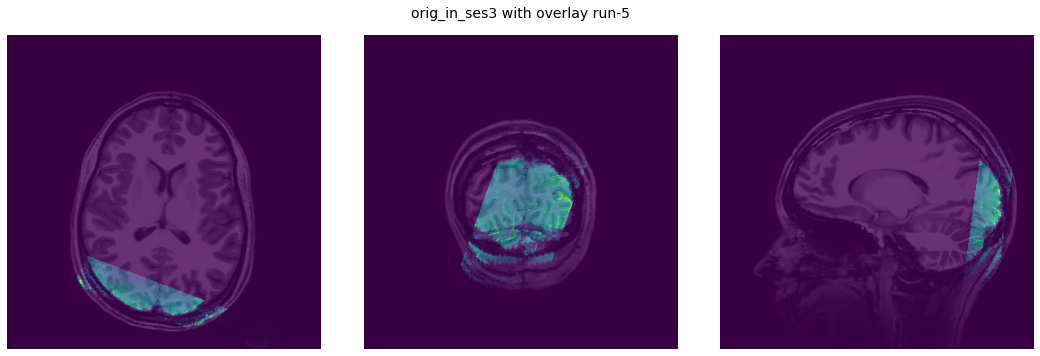

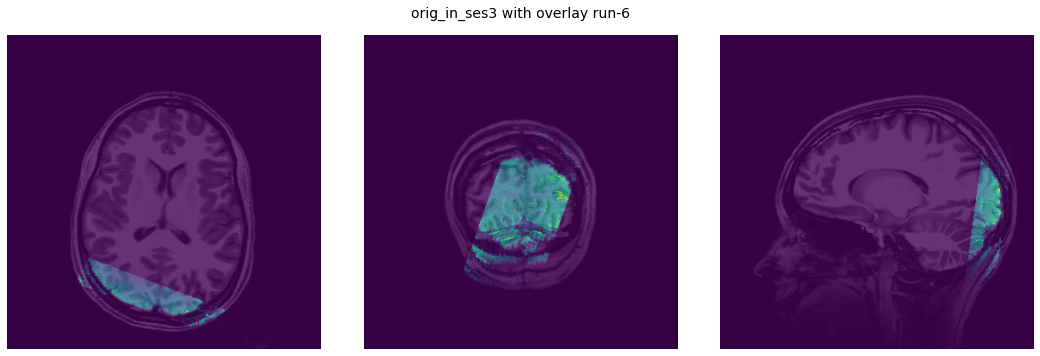

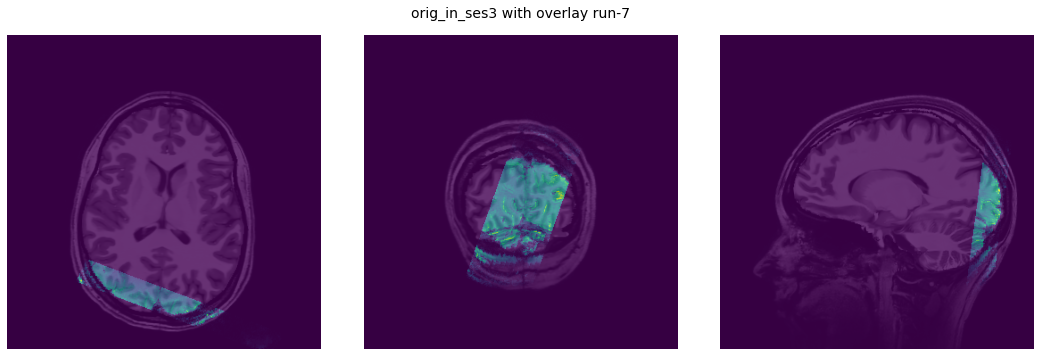

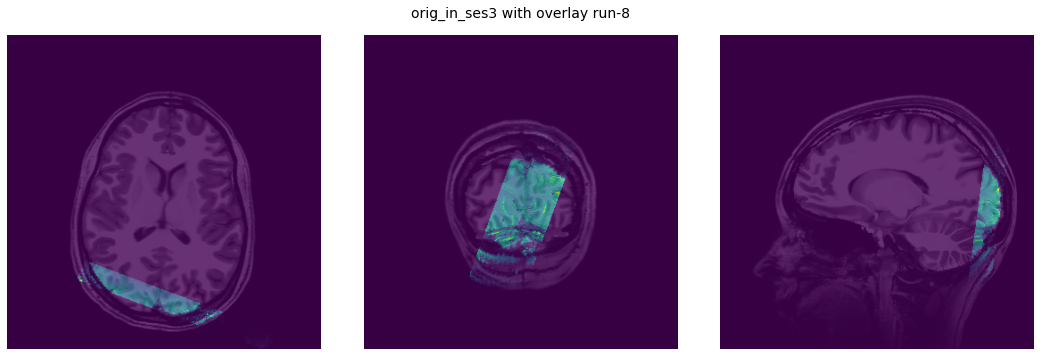

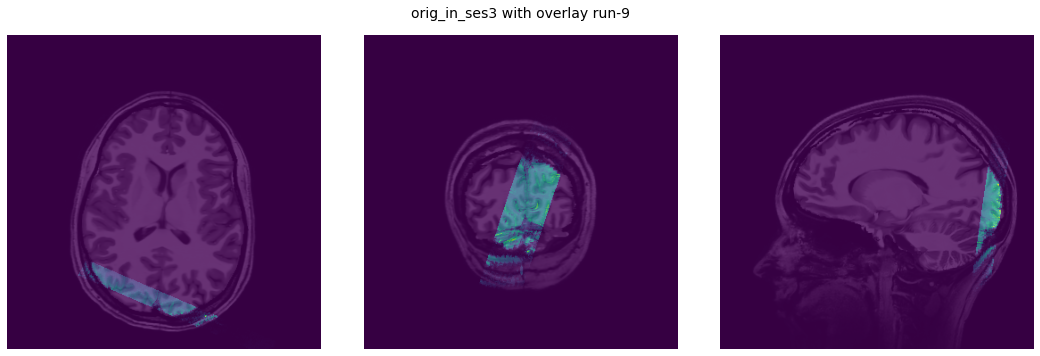

In [10]:
anat_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_anat"
ref = opj(anat_dir, "orig_in_ses3.nii.gz")

include_runs = np.arange(4,10)

for ii in include_runs:
    fname = opj(anat_dir, f"run-{ii}.nii.gz")
    img = PartialFOV(fname, xfm=opj(anat_dir, f"run-{ii}_desc-genaff.mat"))
    img.overlay_ref(ref=ref, alpha=0.8, figsize=(15,5), title=f"orig_in_ses3 with overlay run-{ii}")
    print(f'run-{ii} obliquity = \t {img.affine_to_degrees(unit="rad")}')

Visually, all registrations look pretty decent. It appears, though, that even the 10-slice image is very much useful for registration. It's made slightly complicated as I do not know the ground-truth. We could assume that the 20-slice (run-4) is the ground truth, as that image has the most information available?

Obliquity (as per `nb.affines.obliquity` [obliquity: "*the term obliquity is defined here as the rotation of those axes with respect to the cardinal axes*, https://nipy.org/nibabel/reference/nibabel.affines.html"]) doesn't say too much, I believe. This is because they've all been registered to the same reference. The rotations around center-of-mass (so *inside* the image) is different though (as you can see from the image above). 

## Compare transformation matrices

In [174]:
include_runs = np.arange(4,10)

for ii in include_runs:
    img         = PartialFOV(opj(anat_dir, f"run-{ii}.nii.gz"), xfm=opj(anat_dir, f"run-{ii}_desc-genaff.mat"))
    rotation    = img.return_rotation()
    translation = img.return_translation()

    print(f"translation: {translation}; rotation: {rotation}")

translation: [-3.654  4.145 -7.263]; rotation: [3.256 2.509 2.103]
translation: [-1.356  2.983 -6.561]; rotation: [0.553 0.693 0.666]
translation: [-1.17   1.795 -6.662]; rotation: [0.663 0.769 0.813]
translation: [-0.627  0.585 -6.239]; rotation: [0.558 0.75  0.825]
translation: [-0.104 -0.514 -5.851]; rotation: [0.165 0.653 0.641]
translation: [-1.871 -2.075 -7.253]; rotation: [3.55  2.638 2.512]


It seems that the `10-slice` image produces the most similar parameters as `20-slice`. The ones in between seem to deviate somewhat.

---
# sub-005: Volume coil BOLD

First, BOLD timeseries were motion corrected with `call_fslmcflirt <input>`. We can then take the average of that timeseries as reference volume. We could do this between each run, eventually ending up with `nr_run x reference volumes`. We could then subsequently motion correct these images.

In [11]:
def plot_pars(pars, figsize=(20,8), fontsize=18):

    data = np.loadtxt(pars)
    fig,axs = plt.subplots(2,1, figsize=figsize, sharex=True)

    xx = np.arange(1,data.shape[0]+1)
    
    axs[0].plot(xx,data[:,0], label="roll", color="#FFBF00", lw=2)
    axs[0].plot(xx,data[:,1], label="pitch", color="#FF7F50", lw=2)
    axs[0].plot(xx,data[:,2], label="yaw", color="#DE3163", lw=2)
    axs[0].legend(frameon=False)
    axs[0].set_title("Rotations").set_fontsize(fontsize)
    axs[0].set_ylabel("radians").set_fontsize(fontsize)
    axs[0].get_xaxis().set_visible(False)

    axs[1].plot(xx,data[:,3], label="x", color="#9FE2BF", lw=2)
    axs[1].plot(xx,data[:,4], label="y", color="#40E0D0", lw=2)
    axs[1].plot(xx,data[:,5], label="z", color="#6495ED", lw=2)
    axs[1].legend(frameon=False)
    axs[1].set_title("Translations").set_fontsize(fontsize)
    axs[1].set_ylabel("mm").set_fontsize(fontsize)
    axs[1].set_xlabel("volumes").set_fontsize(fontsize)
    axs[1].set_xticks(xx)
    
    sns.despine(offset=10)
    plt.tight_layout()

Here I load in the data and plot the motion parameters in the BOLD acquisition for 1 run. So this is `NOT` the movement across runs, but within 1 BOLD acquisition. The idea would be to acquire this for multiple runs, motion correct those to the first volume, average them, then concatenate them into a timeseries of `runs x BOLD`, and motion correct *that*

avg mcf shape = (112, 112, 75)


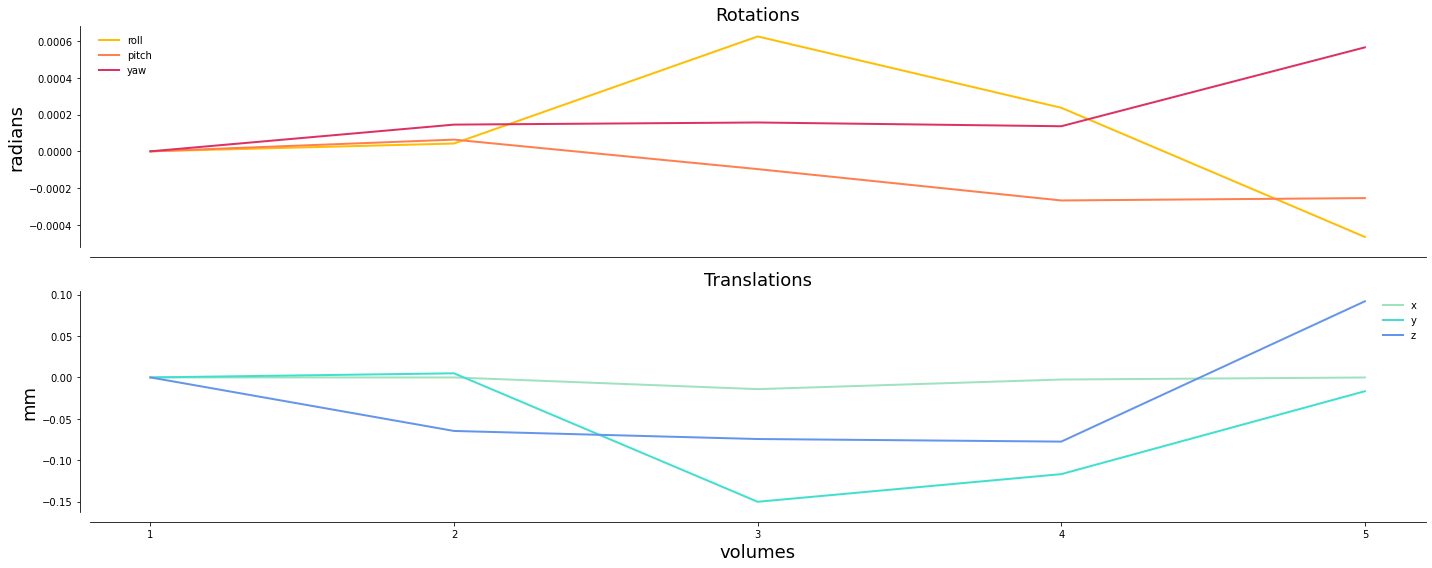

In [12]:
bold_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_bold/nifti"

img_mcf = opj(bold_dir, "sub-001_ses-1_mtx_2DEPI_2mm_1400TR_mcf_avg.nii.gz")
mcf_par = opj(bold_dir, "sub-001_ses-1_mtx_2DEPI_2mm_1400TR_mcf.par")

data_mcf = nb.load(img_mcf).get_fdata()
print(f"avg mcf shape = {data_mcf.shape}")

plot_pars(mcf_par)

After motion correction, I calculated the average over the timeseries and registered that volume to the high resolution anatomical scan with `epi_reg`, with the following steps:

1) Apply `sub-005_from-fs_to-ses3_desc-genaff.mat` to SUBJECTS_DIR/sub-005/mri/orig.nii.gz      > high res data in current session (`orig_in_ses3.nii.gz`)
2) Apply `sub-005_from-fs_to-ses3_desc-genaff.mat` to SUBJECTS_DIR/sub-005/mri/brainmask.mgz    > required to `--t1brain` (`brainmask_in_ses3.nii.gz`)
3) Apply `sub-005_from-fs_to-ses3_desc-genaff.mat` to SUBJECTS_DIR/sub-005/mri/wm.mgz           > skips FAST during `epi_reg` (also do `fslmaths -bin` to binarize!) (`wm_in_ses3.nii.gz`)
4) Do : `epi_reg --epi=sub-001_ses-1_mtx_2DEPI_2mm_1400TR_mcf_avg.nii.gz --t1=orig_in_ses3.nii.gz --t1brain=brainmask_in_ses3.nii.gz --out=bold_in_ses3.nii.gz --wmseg=wm_in_ses3.nii.gz`
5) Convert `bold_in_ses3.mat` to ITK text file with `call_ras2fsl -i orig_in_ses3.nii.gz sub-001_ses-1_mtx_2DEPI_2mm_1400TR_mcf_avg.nii.gz bold_in_ses3.mat bold_in_ses3.txt`
6) Convert `bold_in_ses3.txt` to ITK .mat file with `ConvertTransformFile 3 bold_in_ses3.txt bold_in_ses3_itk.mat --convertToAffineType`


The steps above have now been encapsulate in `linescanning/bin/call_fslepireg`

In [15]:
!call_fslepireg


---------------------------------------------------------------------------------------------------
call_fslepireg

from: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FLIRT/UserGuide
This is a script designed to register EPI images (typically functional or diffusion) to structural 
(e.g. T1-weighted) images. The pre-requisites to use this method are: (1) a structural image that 
can be segmented to give a good white matter boundary; and (2) an EPI that contains some intensity 
contrast between white matter and grey matter (though it does not have to be enough to get a seg-
mentation). This script will either use an existing white-matter segmentation of the structural 
image, or create one itself, to define a white-matter boundary. To use an existing white-matter 
segmentation you can use the --wmseg option. Alternately, there needs to be an image with the same 
basename as the input t1brain image, but ending with _wmseg. We recommend that the structural image 
is bias-corrected separately b

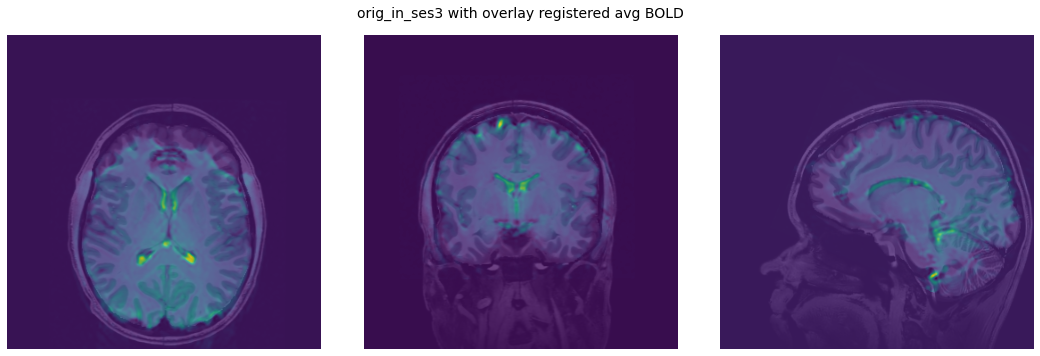

In [13]:
cmap = utils.make_binary_cm("#D01B47")
bold_img = PartialFOV(opj(bold_dir, "bold_in_ses3.nii.gz"), xfm=opj(bold_dir, "bold_in_ses3_itk.mat"), slices=[195,180,150])
bold_img.overlay_ref(ref=opj(bold_dir, "orig_in_ses3.nii.gz"), alpha=0.8, figsize=(15,5), title=f"orig_in_ses3 with overlay registered avg BOLD")

This was about the best registration I could get. This strategy could work with multiple BOLD acquisitions, giving us some idea of movement during the session. I'm still unsure what is better: those multiple high resolution slices of "`swi`", or these `bold` acquisitions. BOLD is definitely faster, but might give slightly less precise results compared to a longer high resolution 'swi' image every run

In [16]:
rotation    = bold_img.return_rotation()
translation = bold_img.return_translation()
print(f"translation: \t {translation}")
print(f"rotation: \t {rotation}")

translation: 	 [-1.95261133 -2.58201792 -0.49804465]
rotation: 	 [0.51802129 1.66752321 1.64253294]
